In [1]:
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
import numpy as np
import scipy.stats
from jax import numpy as jnp
from matplotlib.figure import Figure
from tqdm.notebook import trange

%matplotlib inline

In [2]:
import os
import sys

lib_path = os.path.join(os.path.curdir, "src")
sys.path.insert(0, lib_path)

In [3]:
import importlib

In [5]:
import normal
import network
import activation
import random_matrix
import unscented

importlib.reload(normal)
importlib.reload(unscented)

importlib.reload(random_matrix)
importlib.reload(network)

from normal import Normal
from network import Layer, Network
from random_matrix import RandomGaussian, RandomOrthogonalProjection, ZeroMatrix

In [6]:
key = jax.random.PRNGKey(123)

In [30]:
σ = activation.Sinusoid()

# single layer

In [31]:
f = Layer(
    5,
    1,
    key = key,
    activation=σ,
    A=RandomOrthogonalProjection(1.0),
    b=RandomOrthogonalProjection(0.0),
    C=RandomOrthogonalProjection(0.0),
    d=RandomOrthogonalProjection(0.0),
)
network = Network(f)

In [61]:
dist = Normal(μ=jnp.ones(f.in_size), Σ=1e1 * jnp.eye(f.in_size))

In [62]:
f(dist, method="analytic").Σ

Array([[0.49999769]], dtype=float64)

In [63]:
analytic_output = f(dist, method="analytic")
linear_output = f(dist, method="linear")
unscented_output = f(dist, method="unscented")
mc_output = f._mc_mean_cov(dist, key, 10_000_000)

In [64]:
print("linear mean", linear_output.μ)
print("unscented mean", unscented_output.μ)
print("analytic mean", analytic_output.μ)
print("monte carlo mean", mc_output.μ)

linear mean [-0.22556713]
unscented mean [0.90237997]
analytic mean [-0.00151986]
monte carlo mean [-0.00176848]


In [65]:
print("linear covariance", linear_output.Σ)
print("unscented covariance", unscented_output.Σ)
print("analytic covariance", analytic_output.Σ)
print("monte carlo covariance", mc_output.Σ)

linear covariance [[9.49119468]]
unscented covariance [[12.03662813]]
analytic covariance [[0.49999769]]
monte carlo covariance [[0.49985813]]


In [66]:
print("linear KL", mc_output.kl_divergence(linear_output))
print("unscented KL", mc_output.kl_divergence(unscented_output))
print("analytic KL", mc_output.kl_divergence(analytic_output))

linear KL 7.572090710924023
unscented KL 10.76706803819841
analytic KL 8.131391060484106e-08


# Small-variance test

In [67]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(12), 5)
input_size = 1
output_size = 1
hidden_size = 10
network = Network(
    Layer(
        input_size,
        output_size,
        key=key1,
        activation=σ,
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
        C=ZeroMatrix(),
        d=ZeroMatrix(),
    ),
)
dist = Normal(μ=jnp.zeros(input_size), Σ=jnp.eye(input_size) * 1e-3)

In [68]:
mc_output = network[0]._mc_mean_cov(dist, key=jax.random.PRNGKey(1), rep=1_000_000)
mc_output.μ, mc_output.Σ

(Array([0.84101904], dtype=float64), Array([[0.00029283]], dtype=float64))

In [69]:
analytic_output = network(dist, method="analytic")
analytic_output.μ, analytic_output.Σ

(Array([0.84105035], dtype=float64), Array([[0.00029199]], dtype=float64))

In [70]:
linear_output = network(dist, method="linear")
linear_output.μ, linear_output.Σ

(Array([0.84147098], dtype=float64), Array([[0.00029193]], dtype=float64))

In [71]:
unscented_output = network(dist, method="unscented")
unscented_output.μ, unscented_output.Σ

(Array([0.84062951], dtype=float64), Array([[0.00058527]], dtype=float64))

# Deep MLP

In [74]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(12), 5)
input_size = 2
output_size = 1
hidden_size = 70
network = Network(
    Layer(
        input_size,
        hidden_size,
        key=key1,
        activation=σ,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    Layer(
        hidden_size,
        hidden_size,
        key=key2,
        activation=σ,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    Layer(
        hidden_size,
        hidden_size,
        key=key3,
        activation=σ,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    Layer(
        hidden_size,
        output_size,
        key=key4,
        activation=σ,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
)

In [75]:
μ = jnp.zeros(input_size)
Σ = jnp.eye(input_size)

In [76]:
def plot_mc(ax, μ, Σ):
    dist = Normal(μ, Σ)
    unscented_output = network(dist, method="unscented")
    linear_output = network(dist, method="linear")
    analytic_output = network(dist, method="analytic")

    input_samples = dist.qmc(num_samples=2**10)
    output_samples = jax.vmap(network)(input_samples)

    pseudo = Normal(
        jnp.mean(output_samples).reshape(1, -1), jnp.var(output_samples).reshape(1, 1)
    )

    y_mesh = np.linspace(np.min(output_samples), np.max(output_samples), 2000)

    ax.plot(
        y_mesh,
        scipy.stats.gaussian_kde(output_samples.reshape(-1))(y_mesh),
        label="empirical KDE",
    )
    ax.plot(
        y_mesh,
        jax.vmap(pseudo.pdf)(y_mesh),
        label="pseudo-true Gaussian fit",
    )

    ax.plot(
        y_mesh,
        jax.vmap(unscented_output.pdf)(y_mesh),
        label="unscented approximation",
    )

    ax.plot(
        y_mesh,
        jax.vmap(linear_output.pdf)(y_mesh),
        label="linear approximation",
        linestyle="--",
    )

    ax.plot(
        y_mesh,
        jax.vmap(analytic_output.pdf)(y_mesh),
        label="my approximation",
        linestyle="--",
    )
    ax.legend()

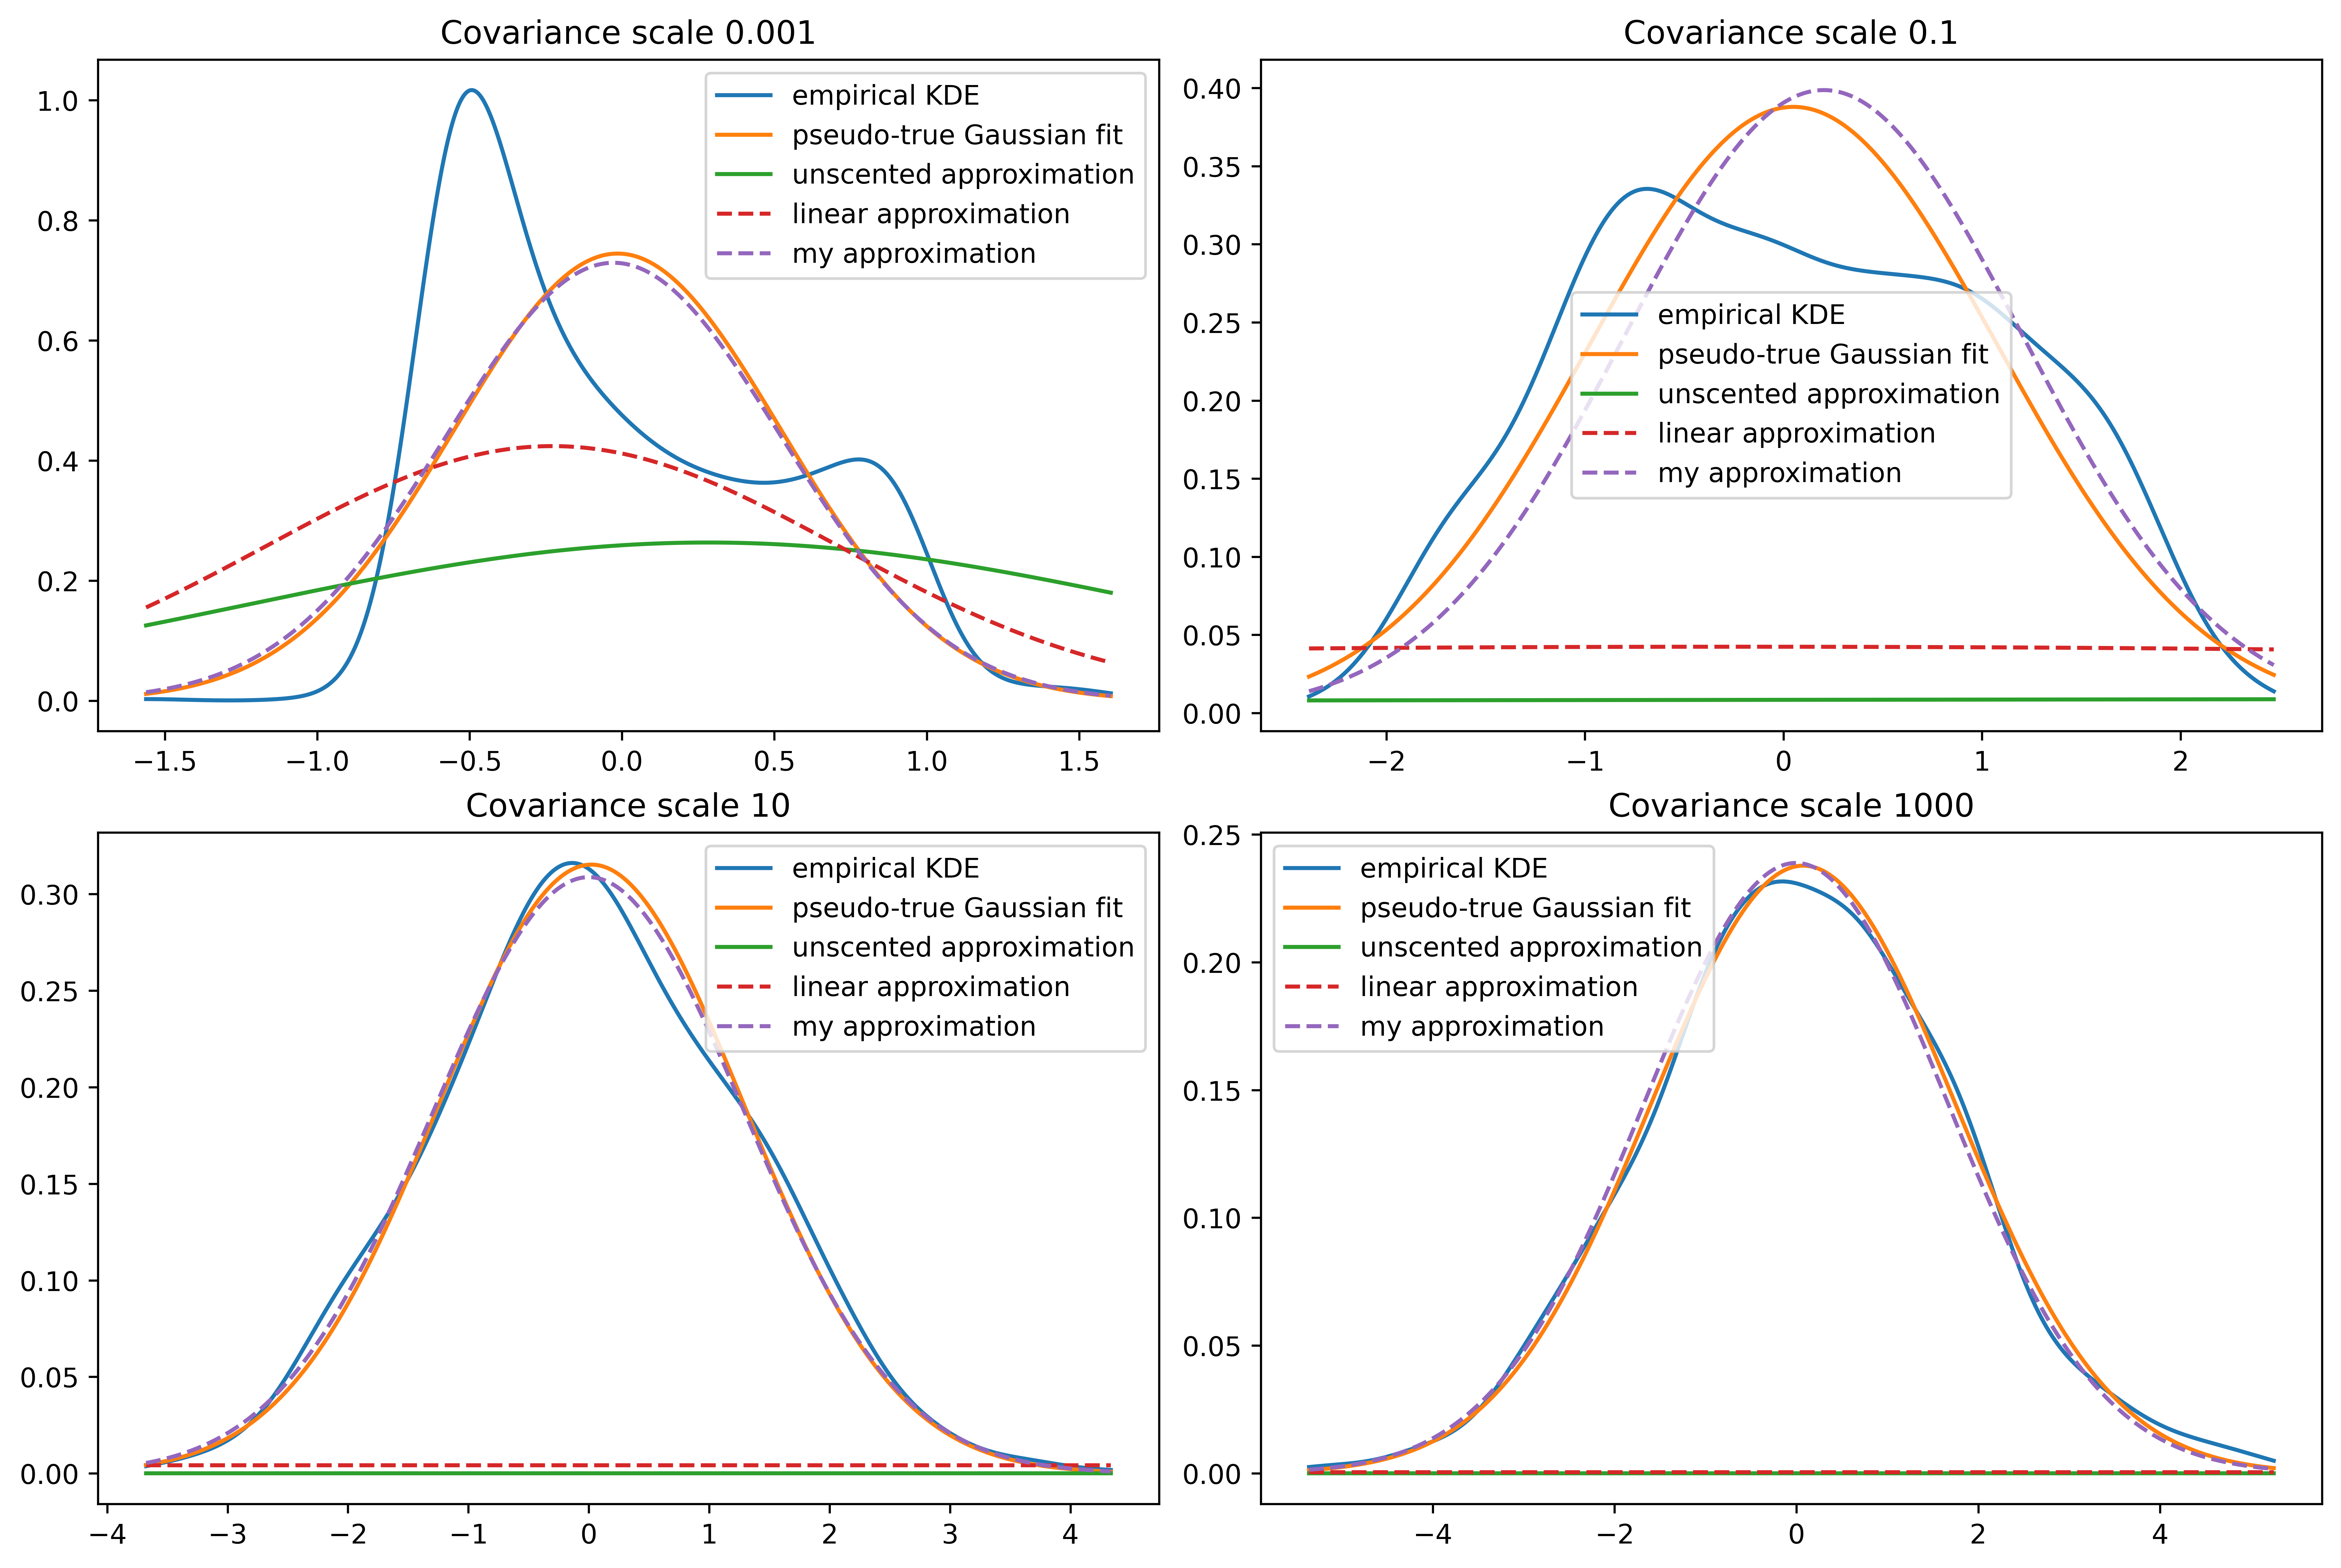

In [77]:
fig = Figure(figsize=(12, 8), dpi=600, constrained_layout=1)
ax = fig.add_subplot(221)
ax.set_title("Covariance scale 0.001")
plot_mc(ax, μ, Σ * 1e-3)
ax = fig.add_subplot(222)
ax.set_title("Covariance scale 0.1")
plot_mc(ax, μ, Σ * 1e-1)
ax = fig.add_subplot(223)
ax.set_title("Covariance scale 10")
plot_mc(ax, μ, Σ * 1e1)
ax = fig.add_subplot(224)
ax.set_title("Covariance scale 1000")
plot_mc(ax, μ, Σ * 1e3)

fig